# Introduction

The solution is adapted from the implementation of a DECI model in the causica library, which can be found [here](https://github.com/microsoft/causica/blob/b3c79a01f30f44ed36c582ffe2b4522058d82a73/causica/models/deci/deci.py), with an associated paper of the original model [here](https://arxiv.org/abs/2202.02195).

The solution is GNN-based, DECI being a generative model that employs an additive noise structural equation model to capture the functional relationships among variables and exogenous noise, while also learning a variational distribution. It is designed to perform causal inference without background information about the causal graph.

The relationships are learnt through flexible neural networks, while the noise can be modeled either as a Gaussian or a spine-flow model. It is considered a generative method, since it essentially evolves from exogenous noise to observations.

Both a mean-field approximate posterior distribution, and the functional relationships, are learned by optimising an evidence lower bound (ELBO).

The implementation itself is based on the popular torch library, and on the causica library, following these steps: it creates prior distributions over directed acyclic graphs (DAGs), it also creates variational posterior distributions over the adjacency matrices, a GNN, for representing functional relationships, and a noise distribution for each node, these last three components being the ones to be optimized. These components are gathered in a structural equation model (SEM), which will be optimized with different learning rates for each module. An Augmented Lagrangian scheduler is employed, that will optimize towards a DAG. The result of the training process will be the adjacency matrix.

Since it is already available, we also try to employ the discretization method, used in the bnlearn solution, to verify whether it helps in any way the learning process.

# 0. Preliminaries

This section includes the required imports, and it also defines the hyperparameters. The notebook can be run locally after following the README instructions in the root directory.

In [1]:
from causica.distributions import ContinuousNoiseDist

from data.csuite.csuite_datasets import *
from data.sachs.sachs_datasets import unaltered_dataset
from evaluation.metrics import eval_all
from models.deci.causica_deci import causica_deci
from utils.solution_utils import hartemink_discretization

In [2]:
train_config = {
    "batch_size": 128,
    "epochs": 1000,
    "init_alpha": 0.0,
    "init_rho": 1.0,
    "gumbel_temp": 0.25,
    "prior_sparsity_lambda": 5.0,
    "embedding_size": 32,
    "out_dim_g": 32,
    "num_layers_g": 2,
    "num_layers_zeta": 2,
    "noise_dist": ContinuousNoiseDist.SPLINE
}

# 1. Observational Set (Sachs)

In [3]:
# Without discretization
print("~~~~~ WITHOUT DISCRETIZATION ~~~~~")
df, gt_graph = unaltered_dataset(get_data=True, return_index_name_correlation=False, return_adjacency_graph=True)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

# With discretization
print("\n\n\n~~~~~ WITH DISCRETIZATION ~~~~~")
df = hartemink_discretization(df)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

~~~~~ WITHOUT DISCRETIZATION ~~~~~
epoch:0 loss:3.0279e+05 nll:3.0279e+05 dagness:5.34188 num_edges:28 alpha:0 rho:1 step:0|1 num_lr_updates:0
epoch:100 loss:11934 nll:11934 dagness:38.23705 num_edges:53 alpha:0 rho:1 step:0|701 num_lr_updates:0
epoch:200 loss:2990.1 nll:2989.8 dagness:28.87832 num_edges:50 alpha:0 rho:1 step:0|1401 num_lr_updates:0
epoch:300 loss:1755 nll:1754.7 dagness:22.02489 num_edges:48 alpha:0 rho:1 step:0|2101 num_lr_updates:0
epoch:400 loss:1189.5 nll:1189.2 dagness:30.51480 num_edges:48 alpha:0 rho:1 step:0|2801 num_lr_updates:0
Updating alpha to: 25.203094482421875
epoch:500 loss:497.13 nll:496.89 dagness:1.17651 num_edges:36 alpha:25.203 rho:1 step:1|501 num_lr_updates:0
epoch:600 loss:492.5 nll:492.27 dagness:1.17651 num_edges:34 alpha:25.203 rho:1 step:1|1201 num_lr_updates:0
epoch:700 loss:258.21 nll:257.99 dagness:1.17651 num_edges:33 alpha:25.203 rho:1 step:1|1901 num_lr_updates:0
epoch:800 loss:197.57 nll:197.35 dagness:1.17651 num_edges:32 alpha:25.2

# 2. Synthetic Set (CSuite)

In [4]:
# ~~~~~~~~ LINGAUSS ~~~~~~~~
csuite_dataset = lingauss

# Without discretization
print("~~~~~ WITHOUT DISCRETIZATION ~~~~~")
df, gt_graph = csuite_dataset(2000, True, True)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

# With discretization
print("\n\n\n~~~~~ WITH DISCRETIZATION ~~~~~")
df = hartemink_discretization(df)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

~~~~~ WITHOUT DISCRETIZATION ~~~~~
epoch:0 loss:3.0199 nll:3.0179 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:0|1 num_lr_updates:0
Updating alpha to: 0.0
epoch:100 loss:2.771 nll:2.7686 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:1|335 num_lr_updates:0
Updating alpha to: 0.0
epoch:200 loss:2.486 nll:2.4835 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:2|611 num_lr_updates:1
Updating alpha to: 0.0
Updating alpha to: 0.0
epoch:300 loss:2.5766 nll:2.5741 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:4|131 num_lr_updates:0
Updating alpha to: 0.0
epoch:400 loss:2.7435 nll:2.741 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:5|438 num_lr_updates:0
epoch:500 loss:2.6145 nll:2.612 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:5|2038 num_lr_updates:1
epoch:600 loss:2.6867 nll:2.6842 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:5|3638 num_lr_updates:1
epoch:700 loss:2.727 nll:2.7246 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:5|5238 num_lr_updates:1
epoch:800 loss:2.7463 nll:2.7438

In [5]:
# ~~~~~~~~ LINEXP ~~~~~~~~
csuite_dataset = linexp

# Without discretization
print("~~~~~ WITHOUT DISCRETIZATION ~~~~~")
df, gt_graph = csuite_dataset(2000, True, True)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

# With discretization
print("\n\n\n~~~~~ WITH DISCRETIZATION ~~~~~")
df = hartemink_discretization(df)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

~~~~~ WITHOUT DISCRETIZATION ~~~~~
epoch:0 loss:2.9267 nll:2.9247 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:0|1 num_lr_updates:0
epoch:100 loss:2.1235 nll:2.121 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:0|1601 num_lr_updates:0
Updating alpha to: 0.0
epoch:200 loss:2.0187 nll:2.0162 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:1|531 num_lr_updates:1
Updating alpha to: 0.0
epoch:300 loss:1.9144 nll:1.9119 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:2|691 num_lr_updates:0
Updating alpha to: 0.0
epoch:400 loss:2.0911 nll:2.0886 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:3|550 num_lr_updates:1
Updating alpha to: 0.0
Updating alpha to: 0.0
epoch:500 loss:1.9914 nll:1.9889 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:5|23 num_lr_updates:0
epoch:600 loss:1.7264 nll:1.7239 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:5|1623 num_lr_updates:3
epoch:700 loss:1.9537 nll:1.9512 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:5|3223 num_lr_updates:3
epoch:800 loss:1.9224 nll:1.9

In [6]:
# ~~~~~~~~ NONLINGAUSS ~~~~~~~~
csuite_dataset = nonlingauss

# Without discretization
print("~~~~~ WITHOUT DISCRETIZATION ~~~~~")
df, gt_graph = csuite_dataset(2000, True, True)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

# With discretization
print("\n\n\n~~~~~ WITH DISCRETIZATION ~~~~~")
df = hartemink_discretization(df)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

~~~~~ WITHOUT DISCRETIZATION ~~~~~
epoch:0 loss:3.6213 nll:3.6193 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:0|1 num_lr_updates:0
epoch:100 loss:2.2258 nll:2.2233 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:0|1601 num_lr_updates:1
Updating alpha to: 0.0
epoch:200 loss:2.3897 nll:2.3873 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:1|1221 num_lr_updates:2
Updating alpha to: 0.0
Updating alpha to: 0.0
epoch:300 loss:2.1486 nll:2.1461 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:3|703 num_lr_updates:1
Updating alpha to: 0.0
epoch:400 loss:2.3465 nll:2.344 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:4|1155 num_lr_updates:1
Updating alpha to: 0.0
epoch:500 loss:2.1007 nll:2.0982 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:5|1398 num_lr_updates:2
epoch:600 loss:2.0261 nll:2.0236 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:5|2998 num_lr_updates:3
epoch:700 loss:2.1283 nll:2.1258 dagness:0.00000 num_edges:1 alpha:0 rho:1 step:5|4598 num_lr_updates:3
epoch:800 loss:2.3355 nll

In [7]:
# ~~~~~~~~ NONLIN SIMPSON ~~~~~~~~
csuite_dataset = nonlin_simpson

# Without discretization
print("~~~~~ WITHOUT DISCRETIZATION ~~~~~")
df, gt_graph = csuite_dataset(2000, True, True)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

# With discretization
print("\n\n\n~~~~~ WITH DISCRETIZATION ~~~~~")
df = hartemink_discretization(df)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

~~~~~ WITHOUT DISCRETIZATION ~~~~~
epoch:0 loss:6.588 nll:6.5914 dagness:0.00000 num_edges:0 alpha:0 rho:1 step:0|1 num_lr_updates:0
epoch:100 loss:1.1577 nll:1.1428 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|1601 num_lr_updates:1
Updating alpha to: 1.1862878799438477
epoch:200 loss:0.96578 nll:0.95008 dagness:1.18629 num_edges:6 alpha:1.1863 rho:1 step:1|1205 num_lr_updates:1
Updating rho, dag penalty prev:  1.1862878799
epoch:300 loss:0.82451 nll:0.80882 dagness:1.18629 num_edges:6 alpha:1.1863 rho:10 step:2|587 num_lr_updates:0
Updating rho, dag penalty prev:  1.1862878799
epoch:400 loss:0.78335 nll:0.76763 dagness:1.18629 num_edges:6 alpha:1.1863 rho:100 step:3|69 num_lr_updates:0
Updating rho, dag penalty prev:  1.1862878799
epoch:500 loss:0.83881 nll:0.82294 dagness:1.18629 num_edges:6 alpha:1.1863 rho:1000 step:4|406 num_lr_updates:0
Updating rho, dag penalty prev:  1.1862878799
epoch:600 loss:0.98426 nll:0.9668 dagness:1.18629 num_edges:6 alpha:1.1863 rho:10000 step:5|436

In [8]:
# ~~~~~~~~ SYMPROD SIMPSON ~~~~~~~~
csuite_dataset = symprod_simpson

# Without discretization
print("~~~~~ WITHOUT DISCRETIZATION ~~~~~")
df, gt_graph = csuite_dataset(2000, True, True)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

# With discretization
print("\n\n\n~~~~~ WITH DISCRETIZATION ~~~~~")
df = hartemink_discretization(df)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

~~~~~ WITHOUT DISCRETIZATION ~~~~~
epoch:0 loss:7.8643 nll:7.8626 dagness:0.00000 num_edges:2 alpha:0 rho:1 step:0|1 num_lr_updates:0
epoch:100 loss:1.7906 nll:1.7756 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|1601 num_lr_updates:1
Updating alpha to: 1.1862878799438477
epoch:200 loss:2.235 nll:2.2193 dagness:1.18629 num_edges:6 alpha:1.1863 rho:1 step:1|1206 num_lr_updates:1
Updating rho, dag penalty prev:  1.1862878799
epoch:300 loss:1.7948 nll:1.7791 dagness:1.18629 num_edges:6 alpha:1.1863 rho:10 step:2|822 num_lr_updates:1
Updating rho, dag penalty prev:  1.1862878799
epoch:400 loss:1.3995 nll:1.3838 dagness:1.18629 num_edges:6 alpha:1.1863 rho:100 step:3|1011 num_lr_updates:1
Updating rho, dag penalty prev:  1.1862878799
epoch:500 loss:1.5478 nll:1.5319 dagness:1.18629 num_edges:6 alpha:1.1863 rho:1000 step:4|1092 num_lr_updates:1
Updating rho, dag penalty prev:  1.1862878799
epoch:600 loss:1.9512 nll:1.9338 dagness:1.18629 num_edges:6 alpha:1.1863 rho:10000 step:5|651 num_l

In [9]:
# ~~~~~~~~ LARGE BACKDOOR ~~~~~~~~
csuite_dataset = large_backdoor

# Without discretization
print("~~~~~ WITHOUT DISCRETIZATION ~~~~~")
df, gt_graph = csuite_dataset(2000, True, True)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

# With discretization
print("\n\n\n~~~~~ WITH DISCRETIZATION ~~~~~")
df = hartemink_discretization(df)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

~~~~~ WITHOUT DISCRETIZATION ~~~~~
epoch:0 loss:15.098 nll:15.069 dagness:6.18400 num_edges:20 alpha:0 rho:1 step:0|1 num_lr_updates:0
epoch:100 loss:6.4576 nll:6.4092 dagness:6.45935 num_edges:21 alpha:0 rho:1 step:0|1601 num_lr_updates:1
Updating alpha to: 7.314506530761719
epoch:200 loss:6.6152 nll:6.5513 dagness:4.73215 num_edges:19 alpha:7.3145 rho:1 step:1|646 num_lr_updates:0
Updating rho, dag penalty prev:  7.3145065308
epoch:300 loss:6.2776 nll:6.2102 dagness:4.92532 num_edges:20 alpha:7.3145 rho:10 step:2|404 num_lr_updates:0
epoch:400 loss:6.2949 nll:6.2303 dagness:4.73215 num_edges:19 alpha:7.3145 rho:10 step:2|2004 num_lr_updates:1
Updating alpha to: 54.63604736328125
epoch:500 loss:6.6028 nll:6.4261 dagness:4.73215 num_edges:19 alpha:54.636 rho:10 step:3|1414 num_lr_updates:2
Updating rho, dag penalty prev:  4.7321538925
epoch:600 loss:6.436 nll:6.2765 dagness:4.18519 num_edges:18 alpha:54.636 rho:100 step:4|1131 num_lr_updates:1
Updating rho, dag penalty prev:  4.7321538

In [10]:
# ~~~~~~~~ WEAK ARROWS ~~~~~~~~
csuite_dataset = weak_arrows

# Without discretization
print("~~~~~ WITHOUT DISCRETIZATION ~~~~~")
df, gt_graph = csuite_dataset(2000, True, True)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

# With discretization
print("\n\n\n~~~~~ WITH DISCRETIZATION ~~~~~")
df = hartemink_discretization(df)
pred_graph = causica_deci(df, train_config, gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

~~~~~ WITHOUT DISCRETIZATION ~~~~~
epoch:0 loss:15.5 nll:15.468 dagness:5.24694 num_edges:21 alpha:0 rho:1 step:0|1 num_lr_updates:0
epoch:100 loss:7.9156 nll:7.8507 dagness:12.01619 num_edges:27 alpha:0 rho:1 step:0|1601 num_lr_updates:1
Updating alpha to: 11.288244247436523
epoch:200 loss:7.6172 nll:7.5251 dagness:6.63588 num_edges:22 alpha:11.288 rho:1 step:1|880 num_lr_updates:0
Updating alpha to: 17.92412567138672
epoch:300 loss:7.4576 nll:7.3433 dagness:6.63588 num_edges:22 alpha:17.924 rho:1 step:2|592 num_lr_updates:0
Updating rho, dag penalty prev:  6.6358814240
epoch:400 loss:7.1753 nll:7.0609 dagness:6.63588 num_edges:22 alpha:17.924 rho:10 step:3|714 num_lr_updates:1
Updating rho, dag penalty prev:  6.6358814240
epoch:500 loss:7.0205 nll:6.9056 dagness:6.63588 num_edges:22 alpha:17.924 rho:100 step:4|652 num_lr_updates:1
Updating rho, dag penalty prev:  6.6358814240
epoch:600 loss:6.8398 nll:6.7199 dagness:6.63588 num_edges:22 alpha:17.924 rho:1000 step:5|963 num_lr_updates

# 3. Hyperparameter tuning
We perform some parameter tuning for the most complex problems, namely large backdoor, weak arrows from the synthetic ones, and Sachs. No discretization performed, since in the previous tests the models trained on quantized data performed worse.

Added significantly larger values for the embedding size and the layer dimensions and switched to a Gaussian noise distribution, since it performed better in a number of tests performed. Only trained on 400 epochs for brevity, with the 3 winning configuration further trained for 2000 epochs to obtain the final results and monitor how the f1 score evolves (whether we have overfitting or not).

In [3]:
# Prepare parameters  
from sklearn.model_selection import ParameterGrid

param_grid = {
    "batch_size": [128],
    "epochs": [400],
    "init_alpha": [0.0],
    "init_rho": [1.0],
    "gumbel_temp": [0.25],
    "prior_sparsity_lambda": [5.0],
    "embedding_size": [32, 128],
    "out_dim_g": [32, 128],
    "num_layers_g": [2, 8],
    "num_layers_zeta": [2, 8],
    "noise_dist": [ContinuousNoiseDist.GAUSSIAN]
}

param_combinations = list(ParameterGrid(param_grid))

## Find optimal parameters

In [7]:
# Large Backdoor tuning
for params in param_combinations:
    print(params)
    df, gt_graph = large_backdoor(2000, True, True)
    pred_graph = causica_deci(df=df, train_config=params, gt_graph=gt_graph)
    print(eval_all(torch.tensor(pred_graph), gt_graph))
    print("\n")

{'batch_size': 128, 'embedding_size': 32, 'epochs': 400, 'gumbel_temp': 0.25, 'init_alpha': 0.0, 'init_rho': 1.0, 'noise_dist': <ContinuousNoiseDist.GAUSSIAN: 'gaussian'>, 'num_layers_g': 2, 'num_layers_zeta': 2, 'out_dim_g': 32, 'prior_sparsity_lambda': 5.0}
epoch:0 loss:16.258 nll:16.23 dagness:7.32789 num_edges:19 alpha:0 rho:1 step:0|1 num_lr_updates:0
{'adjacency_f1': 0.0, 'orientation_f1': 0.0}
epoch:100 loss:7.0936 nll:7.0329 dagness:10.50410 num_edges:26 alpha:0 rho:1 step:0|1601 num_lr_updates:0
{'adjacency_f1': 0.5625, 'orientation_f1': 0.25}
Updating alpha to: 10.914478302001953
epoch:200 loss:7.253 nll:7.1797 dagness:3.94274 num_edges:21 alpha:10.914 rho:1 step:1|661 num_lr_updates:0
{'adjacency_f1': 0.5999999642372131, 'orientation_f1': 0.2666666805744171}
Updating alpha to: 14.857218742370605
epoch:300 loss:7.2593 nll:7.1779 dagness:3.94274 num_edges:21 alpha:14.857 rho:1 step:2|184 num_lr_updates:0
{'adjacency_f1': 0.5999999642372131, 'orientation_f1': 0.2666666805744171

In [6]:
# Weak arrows tuning
for params in param_combinations:
    print(params)
    df, gt_graph = weak_arrows(2000, True, True)
    pred_graph = causica_deci(df=df, train_config=params, gt_graph=gt_graph)
    print(eval_all(torch.tensor(pred_graph), gt_graph))
    print("\n")

{'batch_size': 128, 'embedding_size': 32, 'epochs': 400, 'gumbel_temp': 0.25, 'init_alpha': 0.0, 'init_rho': 1.0, 'noise_dist': <ContinuousNoiseDist.GAUSSIAN: 'gaussian'>, 'num_layers_g': 2, 'num_layers_zeta': 2, 'out_dim_g': 32, 'prior_sparsity_lambda': 5.0}
epoch:0 loss:17.407 nll:17.388 dagness:1.63362 num_edges:16 alpha:0 rho:1 step:0|1 num_lr_updates:0
{'adjacency_f1': 0.0, 'orientation_f1': 0.0}
epoch:100 loss:7.5524 nll:7.4844 dagness:10.70894 num_edges:28 alpha:0 rho:1 step:0|1601 num_lr_updates:1
{'adjacency_f1': 0.6363636255264282, 'orientation_f1': 0.27272728085517883}
Updating alpha to: 11.550867080688477
epoch:200 loss:8.0579 nll:7.9609 dagness:6.08212 num_edges:25 alpha:11.551 rho:1 step:1|886 num_lr_updates:1
{'adjacency_f1': 0.6499999761581421, 'orientation_f1': 0.30000001192092896}
Updating alpha to: 17.632984161376953
epoch:300 loss:7.6261 nll:7.5102 dagness:6.08212 num_edges:25 alpha:17.633 rho:1 step:2|1035 num_lr_updates:0
{'adjacency_f1': 0.6499999761581421, 'orie

In [5]:
# Sachs tuning
for params in param_combinations:
    print(params)
    df, gt_graph = unaltered_dataset(get_data=True, return_index_name_correlation=False, return_adjacency_graph=True)
    pred_graph = causica_deci(df=df, train_config=params, gt_graph=gt_graph)
    print(eval_all(torch.tensor(pred_graph), gt_graph))
    print("\n")

{'batch_size': 128, 'embedding_size': 32, 'epochs': 400, 'gumbel_temp': 0.25, 'init_alpha': 0.0, 'init_rho': 1.0, 'noise_dist': <ContinuousNoiseDist.GAUSSIAN: 'gaussian'>, 'num_layers_g': 2, 'num_layers_zeta': 2, 'out_dim_g': 32, 'prior_sparsity_lambda': 5.0}
epoch:0 loss:1.9803e+05 nll:1.9803e+05 dagness:6.06509 num_edges:26 alpha:0 rho:1 step:0|1 num_lr_updates:0
{'adjacency_f1': 0.0, 'orientation_f1': 0.0}
epoch:100 loss:20070 nll:20069 dagness:46.36248 num_edges:53 alpha:0 rho:1 step:0|701 num_lr_updates:0
{'adjacency_f1': 0.4776119589805603, 'orientation_f1': 0.1492537409067154}
epoch:200 loss:8878.2 nll:8877.8 dagness:93.72311 num_edges:56 alpha:0 rho:1 step:0|1401 num_lr_updates:0
{'adjacency_f1': 0.46153849363327026, 'orientation_f1': 0.1538461446762085}
epoch:300 loss:4248.5 nll:4248.3 dagness:24.98982 num_edges:44 alpha:0 rho:1 step:0|2101 num_lr_updates:0
{'adjacency_f1': 0.4516129195690155, 'orientation_f1': 0.16129031777381897}
{'adjacency_f1': 0.46666669845581055, 'orient

## Train using previously found optimal parameters

In [9]:
# Large backdoor
# Best adjacency
train_config = {
    "batch_size": 128,
    "epochs": 2000,
    "init_alpha": 0.0,
    "init_rho": 1.0,
    "gumbel_temp": 0.25,
    "prior_sparsity_lambda": 5.0,
    "embedding_size": 32,
    "out_dim_g": 128,
    "num_layers_g": 2,
    "num_layers_zeta": 2,
    "noise_dist": ContinuousNoiseDist.GAUSSIAN
}

df, gt_graph = large_backdoor(2000, True, True)
pred_graph = causica_deci(df=df, train_config=train_config, gt_graph=gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

epoch:0 loss:20.597 nll:20.562 dagness:5.30059 num_edges:22 alpha:0 rho:1 step:0|1 num_lr_updates:0
{'adjacency_f1': 0.0, 'orientation_f1': 0.0}
epoch:100 loss:6.7961 nll:6.7413 dagness:9.18540 num_edges:24 alpha:0 rho:1 step:0|1601 num_lr_updates:0
{'adjacency_f1': 0.5925925970077515, 'orientation_f1': 0.37037038803100586}
Updating alpha to: 5.073260307312012
epoch:200 loss:7.1856 nll:7.1297 dagness:4.01760 num_edges:19 alpha:5.0733 rho:1 step:1|564 num_lr_updates:0
{'adjacency_f1': 0.5925925970077515, 'orientation_f1': 0.37037038803100586}
Updating rho, dag penalty prev:  5.0732603073
epoch:300 loss:6.6535 nll:6.5916 dagness:4.12059 num_edges:21 alpha:5.0733 rho:10 step:2|689 num_lr_updates:0
{'adjacency_f1': 0.5925925970077515, 'orientation_f1': 0.37037038803100586}
Updating rho, dag penalty prev:  5.0732603073
epoch:400 loss:6.9693 nll:6.9128 dagness:4.02309 num_edges:19 alpha:5.0733 rho:100 step:3|133 num_lr_updates:0
{'adjacency_f1': 0.5925925970077515, 'orientation_f1': 0.370370

In [10]:
# Large backdoor
# Best orientation
train_config = {
    "batch_size": 128,
    "epochs": 2000,
    "init_alpha": 0.0,
    "init_rho": 1.0,
    "gumbel_temp": 0.25,
    "prior_sparsity_lambda": 5.0,
    "embedding_size": 32,
    "out_dim_g": 128,
    "num_layers_g": 2,
    "num_layers_zeta": 8,
    "noise_dist": ContinuousNoiseDist.GAUSSIAN
}

df, gt_graph = large_backdoor(2000, True, True)
pred_graph = causica_deci(df=df, train_config=train_config, gt_graph=gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

epoch:0 loss:14.614 nll:14.596 dagness:1.59034 num_edges:15 alpha:0 rho:1 step:0|1 num_lr_updates:0
{'adjacency_f1': 0.0, 'orientation_f1': 0.0}
epoch:100 loss:7.0395 nll:6.9918 dagness:6.70175 num_edges:21 alpha:0 rho:1 step:0|1601 num_lr_updates:1
{'adjacency_f1': 0.5999999642372131, 'orientation_f1': 0.2666666805744171}
Updating alpha to: 9.043880462646484
epoch:200 loss:7.0506 nll:6.9748 dagness:5.89215 num_edges:20 alpha:9.0439 rho:1 step:1|1058 num_lr_updates:1
{'adjacency_f1': 0.6206896305084229, 'orientation_f1': 0.27586206793785095}
Updating rho, dag penalty prev:  9.0438804626
epoch:300 loss:6.4607 nll:6.3845 dagness:5.89215 num_edges:20 alpha:9.0439 rho:10 step:2|1279 num_lr_updates:1
{'adjacency_f1': 0.6206896305084229, 'orientation_f1': 0.27586206793785095}
Updating rho, dag penalty prev:  9.0438804626
epoch:400 loss:6.7734 nll:6.6966 dagness:5.89215 num_edges:20 alpha:9.0439 rho:100 step:3|964 num_lr_updates:1
{'adjacency_f1': 0.6206896305084229, 'orientation_f1': 0.27586

In [11]:
# Weak arrows
train_config = {
    "batch_size": 128,
    "epochs": 2000,
    "init_alpha": 0.0,
    "init_rho": 1.0,
    "gumbel_temp": 0.25,
    "prior_sparsity_lambda": 5.0,
    "embedding_size": 32,
    "out_dim_g": 32,
    "num_layers_g": 2,
    "num_layers_zeta": 8,
    "noise_dist": ContinuousNoiseDist.GAUSSIAN
}

df, gt_graph = weak_arrows(2000, True, True)
pred_graph = causica_deci(df=df, train_config=train_config, gt_graph=gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

epoch:0 loss:14.057 nll:14.02 dagness:7.41425 num_edges:23 alpha:0 rho:1 step:0|1 num_lr_updates:0
{'adjacency_f1': 0.0, 'orientation_f1': 0.0}
epoch:100 loss:7.4631 nll:7.4155 dagness:4.12726 num_edges:21 alpha:0 rho:1 step:0|1601 num_lr_updates:1
{'adjacency_f1': 0.6857142448425293, 'orientation_f1': 0.3999999761581421}
Updating alpha to: 2.967510223388672
epoch:200 loss:7.7377 nll:7.6916 dagness:2.60916 num_edges:18 alpha:2.9675 rho:1 step:1|790 num_lr_updates:1
{'adjacency_f1': 0.6666666269302368, 'orientation_f1': 0.42424243688583374}
Updating rho, dag penalty prev:  2.9675102234
epoch:300 loss:7.2103 nll:7.1544 dagness:5.07441 num_edges:20 alpha:2.9675 rho:10 step:2|1059 num_lr_updates:1
{'adjacency_f1': 0.6470588445663452, 'orientation_f1': 0.4117647111415863}
Updating rho, dag penalty prev:  2.9675102234
epoch:400 loss:7.4556 nll:7.4041 dagness:3.30341 num_edges:19 alpha:2.9675 rho:100 step:3|722 num_lr_updates:0
{'adjacency_f1': 0.6470588445663452, 'orientation_f1': 0.41176471

In [15]:
# Sachs
# Best adjacency
train_config = {
    "batch_size": 128,
    "epochs": 2000,
    "init_alpha": 0.0,
    "init_rho": 1.0,
    "gumbel_temp": 0.25,
    "prior_sparsity_lambda": 5.0,
    "embedding_size": 128,
    "out_dim_g": 128,
    "num_layers_g": 2,
    "num_layers_zeta": 8,
    "noise_dist": ContinuousNoiseDist.GAUSSIAN
}

df, gt_graph = unaltered_dataset(get_data=True, return_index_name_correlation=False, return_adjacency_graph=True)
pred_graph = causica_deci(df=df, train_config=train_config, gt_graph=gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

epoch:0 loss:2.1826e+05 nll:2.1826e+05 dagness:8.65077 num_edges:29 alpha:0 rho:1 step:0|1 num_lr_updates:0
{'adjacency_f1': 0.0, 'orientation_f1': 0.0}
epoch:100 loss:24728 nll:24728 dagness:35.30795 num_edges:43 alpha:0 rho:1 step:0|701 num_lr_updates:0
{'adjacency_f1': 0.43636366724967957, 'orientation_f1': 0.3272727429866791}
epoch:200 loss:9329.8 nll:9329.6 dagness:19.78573 num_edges:41 alpha:0 rho:1 step:0|1401 num_lr_updates:0
{'adjacency_f1': 0.46808508038520813, 'orientation_f1': 0.3404255211353302}
epoch:300 loss:4239.9 nll:4239.7 dagness:12.64287 num_edges:35 alpha:0 rho:1 step:0|2101 num_lr_updates:0
{'adjacency_f1': 0.41860464215278625, 'orientation_f1': 0.3255814015865326}
epoch:400 loss:3071.4 nll:3071.2 dagness:23.22682 num_edges:36 alpha:0 rho:1 step:0|2801 num_lr_updates:0
{'adjacency_f1': 0.46808508038520813, 'orientation_f1': 0.38297873735427856}
Updating alpha to: 11.391542434692383
epoch:500 loss:1440.9 nll:1440.7 dagness:6.01216 num_edges:29 alpha:11.392 rho:1 st

In [14]:
# Sachs
# Best orientation
train_config = {
    "batch_size": 128,
    "epochs": 2000,
    "init_alpha": 0.0,
    "init_rho": 1.0,
    "gumbel_temp": 0.25,
    "prior_sparsity_lambda": 5.0,
    "embedding_size": 128,
    "out_dim_g": 32,
    "num_layers_g": 2,
    "num_layers_zeta": 2,
    "noise_dist": ContinuousNoiseDist.GAUSSIAN
}

df, gt_graph = unaltered_dataset(get_data=True, return_index_name_correlation=False, return_adjacency_graph=True)
pred_graph = causica_deci(df=df, train_config=train_config, gt_graph=gt_graph)
print(eval_all(torch.tensor(pred_graph), gt_graph))

epoch:0 loss:2.8463e+05 nll:2.8463e+05 dagness:9.06053 num_edges:28 alpha:0 rho:1 step:0|1 num_lr_updates:0
{'adjacency_f1': 0.0, 'orientation_f1': 0.0}
epoch:100 loss:26374 nll:26374 dagness:26.76184 num_edges:44 alpha:0 rho:1 step:0|701 num_lr_updates:0
{'adjacency_f1': 0.41791048645973206, 'orientation_f1': 0.20895524322986603}
epoch:200 loss:11223 nll:11223 dagness:48.50584 num_edges:52 alpha:0 rho:1 step:0|1401 num_lr_updates:0
{'adjacency_f1': 0.3999999761581421, 'orientation_f1': 0.2153846174478531}
epoch:300 loss:4914.7 nll:4914.4 dagness:27.89859 num_edges:47 alpha:0 rho:1 step:0|2101 num_lr_updates:0
{'adjacency_f1': 0.3333333134651184, 'orientation_f1': 0.23333334922790527}
epoch:400 loss:2923.5 nll:2923.2 dagness:82.28069 num_edges:53 alpha:0 rho:1 step:0|2801 num_lr_updates:0
{'adjacency_f1': 0.4374999701976776, 'orientation_f1': 0.34375}
Updating alpha to: 53.038230895996094
epoch:500 loss:1948.7 nll:1948.3 dagness:2.45808 num_edges:35 alpha:53.038 rho:1 step:1|501 num_lr

# 4. Conclusions

Very good adjacency scores all around, and good results for the simpler graphs for the orientation too. However, the model starts to struggle on the orientation prediction as the complexity of the graph that needs to be predicted increases.

As expected, almost overall significantly worse results for the discretized data, due to the loss in information, and to the fact that the network used is not designed for categorical data.

As for the hyperparameter search, the synthetic sets got the best results with the default embedding of 32, while Sachs worked best with an embedding size of 128, probably due to it being more complex. Both types of sets had better f1 orientation scores when using more zeta layers (8 vs 2, for best adjacency f1 score).

In the table below, only the non-discretized models are reported, for a better understanding of how the model performs among models of different complexities. The other half of the models is ignored because of the significantly inferior results.

|                     | **Adjacency F1** | **Orientation F1** |
|---------------------|:----------------:|:------------------:|
|        **Lingauss** |       1.00       |        0.00        |
|          **Linexp** |       1.00       |        1.00        |
|     **Nonlingauss** |       1.00       |        1.00        |
|  **Nonlin Simpson** |       0.80       |        0.20        |
| **Symprod Simpson** |       0.80       |        0.20        |
|  **Large Backdoor** |       0.75       |        0.33        |
|     **Weak Arrows** |       0.52       |        0.26        |
|           **Sachs** |       0.42       |        0.23        |

Below, to better understand whether the models overfit and if we would benefit from early stopping, we plot the loss against the 2 f1 scores, at points every 100 epochs for the training done above, with the parameter values obtained through the search process.

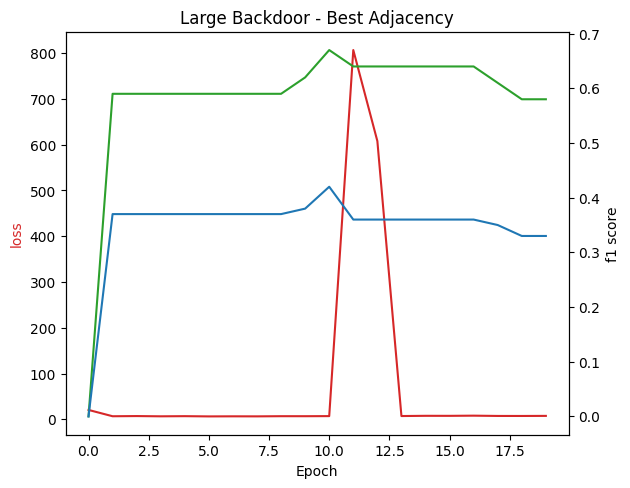

In [25]:
import matplotlib.pyplot as plt

losses = [20.6, 6.8, 7.19, 6.65, 6.97, 6.45, 6.63, 6.54, 6.91, 6.89, 7.09, 806.8, 607.95, 7.24, 7.74, 7.68, 8.07, 7.45, 7.41, 7.59]
f1_adj = [0, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.62, 0.67, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.61, 0.58, 0.58]
f1_orientation = [0, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.38, 0.42, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.35, 0.33, 0.33]

fig, ax1 = plt.subplots()

ax1.plot(np.arange(len(losses)), losses, color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel('loss', color="tab:red")
ax2 = ax1.twinx()
ax2.plot(np.arange(len(losses)), f1_adj, color="tab:green")
ax2.plot(np.arange(len(losses)), f1_orientation, color="tab:blue")
ax2.set_ylabel('f1 score')

fig.tight_layout()

plt.title("Large Backdoor - Best Adjacency")
plt.show()

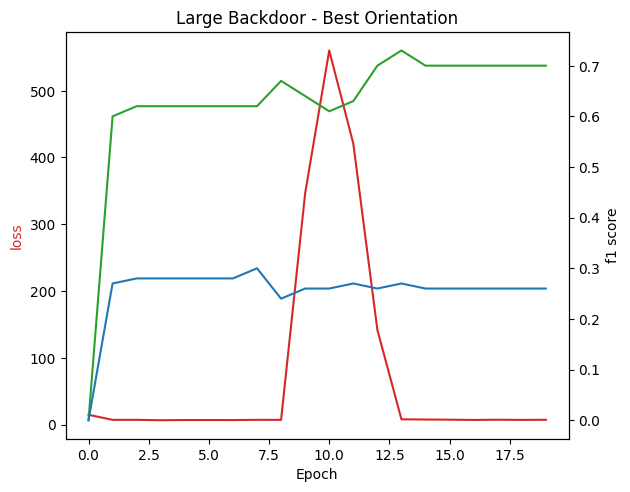

In [26]:
import matplotlib.pyplot as plt

losses = [14.61, 7.04, 7.05, 6.46, 6.77, 6.76, 6.72, 7.06, 7, 346.38, 560.2, 420.8, 141.93 ,7.86, 7.53, 7.3, 6.91, 7.21, 6.95, 7.12]
f1_adj = [0, 0.6, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.67, 0.64, 0.61, 0.63, 0.7, 0.73, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
f1_orientation = [0, 0.27, 0.28, 0.28, 0.28, 0.28, 0.28, 0.3, 0.24, 0.26, 0.26, 0.27, 0.26, 0.27, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26]

fig, ax1 = plt.subplots()

ax1.plot(np.arange(len(losses)), losses, color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel('loss', color="tab:red")
ax2 = ax1.twinx()
ax2.plot(np.arange(len(losses)), f1_adj, color="tab:green")
ax2.plot(np.arange(len(losses)), f1_orientation, color="tab:blue")
ax2.set_ylabel('f1 score')

fig.tight_layout()

plt.title("Large Backdoor - Best Orientation")
plt.show()

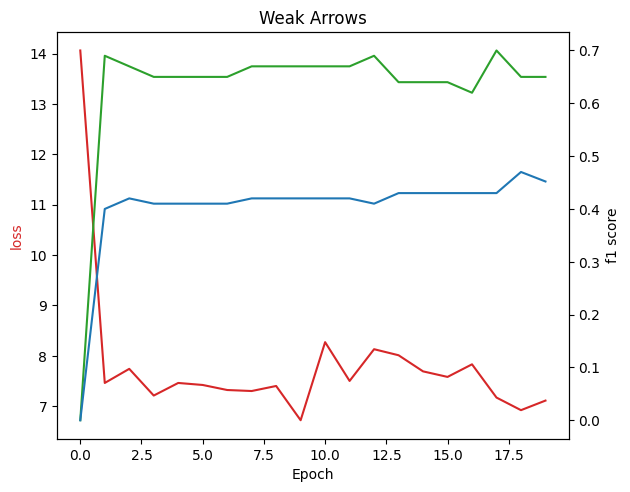

In [27]:
import matplotlib.pyplot as plt

losses = [14.06, 7.46, 7.74, 7.21, 7.46, 7.42, 7.32, 7.3, 7.4, 6.72, 8.27, 7.5, 8.13, 8.01, 7.69, 7.58, 7.83, 7.17, 6.92, 7.11]
f1_adj = [0, 0.69, 0.67, 0.65, 0.65, 0.65, 0.65, 0.67, 0.67, 0.67, 0.67, 0.67, 0.69, 0.64, 0.64, 0.64, 0.62, 0.7, 0.65, 0.65]
f1_orientation = [0, 0.4, 0.42, 0.41, 0.41, 0.41, 0.41, 0.42, 0.42, 0.42, 0.42, 0.42, 0.41, 0.43, 0.43, 0.43, 0.43, 0.43, 0.47, 0.452]

fig, ax1 = plt.subplots()

ax1.plot(np.arange(len(losses)), losses, color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel('loss', color="tab:red")
ax2 = ax1.twinx()
ax2.plot(np.arange(len(losses)), f1_adj, color="tab:green")
ax2.plot(np.arange(len(losses)), f1_orientation, color="tab:blue")
ax2.set_ylabel('f1 score')

fig.tight_layout()

plt.title("Weak Arrows")
plt.show()

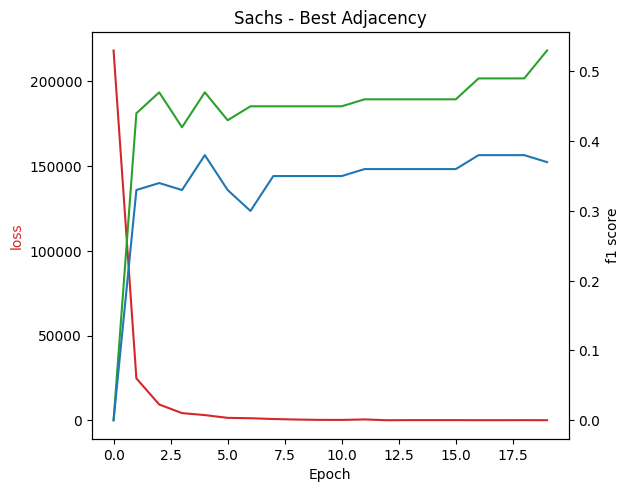

In [28]:
import matplotlib.pyplot as plt

losses = [218260, 24728, 9329, 4239, 3071, 1440, 1225, 759, 448, 249, 218, 505, 37, 107, 97, 98, 65, 74, 94, 60]
f1_adj = [0, 0.44, 0.47, 0.42, 0.47, 0.43, 0.45, 0.45, 0.45, 0.45, 0.45, 0.46, 0.46, 0.46, 0.46, 0.46, 0.49, 0.49, 0.49, 0.53]
f1_orientation = [0, 0.33, 0.34, 0.33, 0.38, 0.33, 0.3, 0.35, 0.35, 0.35, 0.35, 0.36, 0.36, 0.36, 0.36, 0.36, 0.38, 0.38, 0.38, 0.37]

fig, ax1 = plt.subplots()

ax1.plot(np.arange(len(losses)), losses, color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel('loss', color="tab:red")
ax2 = ax1.twinx()
ax2.plot(np.arange(len(losses)), f1_adj, color="tab:green")
ax2.plot(np.arange(len(losses)), f1_orientation, color="tab:blue")
ax2.set_ylabel('f1 score')

fig.tight_layout()

plt.title("Sachs - Best Adjacency")
plt.show()

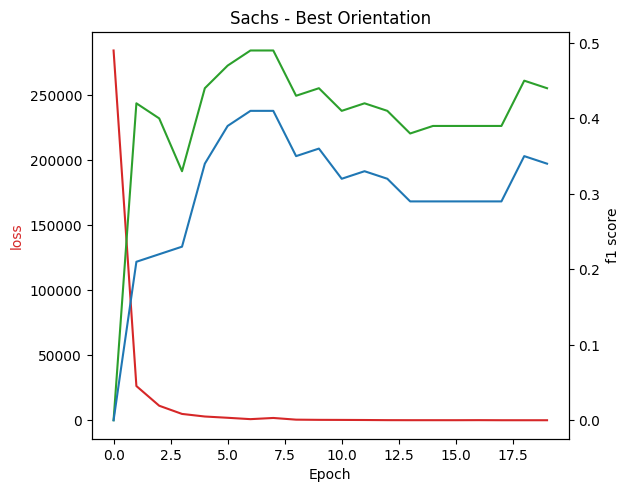

In [29]:
import matplotlib.pyplot as plt

losses = [284630, 26374, 11223, 4914, 2924, 1949, 900, 1806, 511, 357, 307, 237, 124, 95, 92, 86, 132, 66, 60, 62]
f1_adj = [0, 0.42, 0.4, 0.33, 0.44, 0.47, 0.49, 0.49, 0.43, 0.44, 0.41, 0.42, 0.41, 0.38, 0.39, 0.39, 0.39, 0.39, 0.45, 0.44]
f1_orientation = [0, 0.21, 0.22, 0.23, 0.34, 0.39, 0.41, 0.41, 0.35, 0.36, 0.32, 0.33, 0.32, 0.29, 0.29, 0.29, 0.29, 0.29, 0.35, 0.34]

fig, ax1 = plt.subplots()

ax1.plot(np.arange(len(losses)), losses, color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel('loss', color="tab:red")
ax2 = ax1.twinx()
ax2.plot(np.arange(len(losses)), f1_adj, color="tab:green")
ax2.plot(np.arange(len(losses)), f1_orientation, color="tab:blue")
ax2.set_ylabel('f1 score')

fig.tight_layout()

plt.title("Sachs - Best Orientation")
plt.show()

The large backdoor struggles during training, with unusually large spikes in the loss around the 10th epoch and decrease in both f1 scores around the same time for one of the models. Sachs has a more stable evolution of the loss compared to weak arrows, but both exhibit problems where the f1 scores max out earlier than the minimum point of the loss. This could be an indication that the loss is not completely reflective of the target score, and it may need to be tweaked.

More experimentation may be needed though, through the usage of multiple seeds, in order to obtain more stable results.